# Wine Classification
We try to classify wines to "bad" and "good" wines using Naive Bayes Classifier in order to explore the difference between words used to describe "bad" and "good".

The notebook is also avaiable as a [GitHub repository](https://github.com/DostalJ/WineReviews).

In [1]:
import pandas as pd
from pandas import options
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from matplotlib.style import use
use('ggplot')
options.mode.chained_assignment = None  # default='warn'
%load_ext Cython

In [2]:
df = pd.read_csv('./data/winemag-data_first150k.csv')
df.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
# df['description'].apply(func=lambda text: len(word_tokenize(text))).hist()
# plt.title('Number of words used to describe a wine.')
# plt.xlabel('Number of words in description.')
# plt.ylabel('Number of reviews.')
# plt.show()

### Data Features
- *Points*: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- *Variety*: the type of grapes used to make the wine (ie Pinot Noir)
- *Description*: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- *Country*: the country that the wine is from
- *Province*: the province or state that the wine is from
- *Region 1*: the wine growing area in a province or state (ie Napa)
- *Region 2*: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- *Winery*: the winery that made the wine
- *Designation*: the vineyard within the winery where the grapes that made the wine are from
- *Price*: the cost for a bottle of the wine

### Explore feature distribution
We are looking for good labels, i.e. indicators of quality of the wine. We'll explore *Points* and *Price* features.

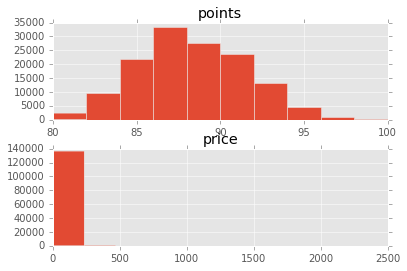

In [4]:
df = df.dropna(subset=['price', 'points'])
df[['price', 'points']].hist(layout=(2,1))
plt.show()

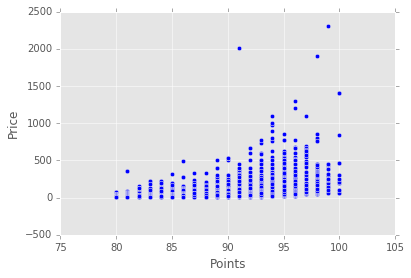

In [5]:
plt.scatter(df['points'], df['price'])
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()

We can see that prize does not add much information. We'll use only *points* as the feature.

## Classification
We'll try to classify the best wines and the worst wines in the dataset. We use 25% of wines with lowest number of points as *"bad"* wines and 25% of wines with the highest number of points as the *"good"* wines.

In [6]:
df = df.dropna(subset=['description'])  # drop all NaNs

df_sorted = df.sort_values(by='points', ascending=True)  # sort by points

num_of_wines = df_sorted.shape[0]  # number of wines
worst = df_sorted.head(int(0.25*num_of_wines))  # 25 % of worst wines listed
best = df_sorted.tail(int(0.25*num_of_wines))  # 25 % of best wines listed

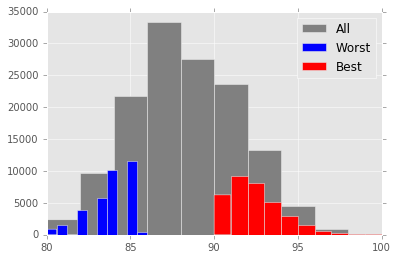

In [7]:
plt.hist(df['points'], color='grey', label='All')
plt.hist(worst['points'], color='blue', label='Worst')
plt.hist(best['points'], color='red', label='Best')
plt.legend()
plt.show()

In [8]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist, NaiveBayesClassifier
from random import shuffle

First we lower all words in description.

In [9]:
worst['words'] = worst['description'].apply(func=lambda text: word_tokenize(text.lower()))
best['words'] = best['description'].apply(func=lambda text: word_tokenize(text.lower()))
worst = worst.dropna(subset=['words'])  # drop all NaNs
best = best.dropna(subset=['words'])  # drop all NaNs

Make dictionary from 3000 most frequent words.

In [10]:
all_words = []  # initialize list of all words
# add all words from 'worst' dataset
for description in worst['words'].values:
    for word in description:
        all_words.append(word)
# add all words from 'best' dataset
for description in best['words'].values:
    for word in description:
        all_words.append(word)
all_words = FreqDist(all_words)  # make FreqList
words_features = list(all_words.keys())[:3000]  # select 3000 most frequent words as words features

We use 3000 long sparse vector as feature vector (0 if feature word is not presented, 1 if feature word is presented).

In [11]:
%%cython
cpdef dict find_features(list doc, list words_features):
    """Function for making features out of the text"""
    cdef set words = set(doc)  # set of words in description
    cdef dict features = {}  # feature dictionary
    cdef str w
    for w in words_features:  # check if any feature word is presented
        features[w] = bool(w in words)  # write to feature vector
    return features  # return feature vector

We make features from dataset and randomly shuffle it.

In [12]:
featureset = ([(find_features(description, words_features), 'worst') for description in worst['words']] +
              [(find_features(description, words_features), 'best') for description in best['words']])
shuffle(featureset)  # randomly shuffle dataset

Now we initialize and train classifier.

In [13]:
classifier = NaiveBayesClassifier.train(labeled_featuresets=featureset)

Print most informative features.

In [14]:
classifier.show_most_informative_features(50)

Most Informative Features
                    2018 = True             best : worst  =     86.5 : 1.0
                now–2013 = True             best : worst  =     81.7 : 1.0
                everyday = True            worst : best   =     69.6 : 1.0
                stunning = True             best : worst  =     48.3 : 1.0
             outstanding = True             best : worst  =     34.1 : 1.0
             nondescript = True            worst : best   =     31.7 : 1.0
               inaugural = True             best : worst  =     31.0 : 1.0
                 burgers = True            worst : best   =     30.5 : 1.0
                   pasty = True            worst : best   =     30.3 : 1.0
                glorious = True             best : worst  =     30.2 : 1.0
              remarkable = True             best : worst  =     28.7 : 1.0
              compelling = True             best : worst  =     28.4 : 1.0
                  owners = True             best : worst  =     27.0 : 1.0